# Practica No 4: Vacunación 


## Nombre:

###       Fernando Sanchez

## Enunciado:

### El proceso de vacunacion es el siguiente:

    - La persona llega 20 minutos antes de la hora de vacuna.
    - Ingresa a la cola/fila a que tome el turno.
    - Tenemos un proceso de control en donde se toma los signos vitales y se valida que este dentro del patron
      de (2-5 minutos)
    - Como ejemplificación menos del 5% no es vacunado ya que presenta signo de alerta.
    - Se procede al traslado al cama/silla de vacunación y se inyecta la dosis de la vacuna este proceso tarda
      entre (5-10 minutos).
    - Finalmente son llevados a la salida entre (1-3 minutos)
    

### Finalmente generar las siguientes metricas/graficas:

    - Tiempo de espera promedio para cada persona.
    - Tiempo promedio total que requiere un paciente para ser vacunado.
    - Cuántos personas se atendieron.
    - Cuántos pacientes se quedaron sin atender.
    
###   * Puntos extras

    - Vincular su investigación con la llegada y distribución de la vacuna.

In [49]:
# Importar librerias necesarias
import simpy
import random
import matplotlib.pyplot as plt

In [157]:
aux = 0
atendidos = 0
# Maximo de vacunas que puede recibir el negocio
MAX_VACUNAS = 200
# Total de numero de mesas para vacunacion
NUM_MESAS = 10
# Total de pacientes para vacunarse
NUM_PACIENTES = 200
promedio10 = (NUM_PACIENTES * 0.05)
# Intervalo de tiempo en que la persona llega 20 minutos
INTERVALO_LLEGADA = 20 #minutos
# Tiempo de simulación, el lugar de vacunacion tiene horario de atencion de 9 horas, en total 540 minutos
horario_atencion = 60 * (9)
TIEMPO_SIMULACION = horario_atencion 
# Intervalo de llegada 
INTERVALO =3
tiempos_llegada = {}

# Diccionario para almacenar tiempo de espera de vacunacion de personas
tiempo_espera_vacunacion=[]
# Diccionario para almacenar tiempo promedio total de vacunacion de personas
tiempo_vacunacion={}
#Diccionario para el numero de personas vacunadas
vacunados =[]
#Diccionario para el numero de personas no vacunadas
no_vacunados = []

horas = []


class Recinto(object):
    def __init__(self, environment, num_juntas):
        # Guardamos como varible el entorno de ejecución 
        self.env=environment
        # Creamos la varible que representa el numero de juntas para la vacunacion
        self.num_juntas = simpy.Resource(environment, num_juntas)
        
    # Método que dicta el tiempo que el paciente espera en la fila    
    def control_signos(self, paciente):
        espera = random.randint(2, 5)
        yield self.env.timeout(espera)
        
    # Método que dicta el tiempo que el paciente espera la vacunación     
    def espera_vacunacion (self, paciente):
        espera = random.randint(5, 10)
        yield self.env.timeout(espera)
        
        k = int(paciente)
        if k in tiempo_vacunacion:
            tiempo_vacunacion[k]=tiempo_vacunacion[k]+1
        else:
            tiempo_vacunacion[k]=espera
        
    # Método que dictal la salida    
    def espera_salida(self, paciente):
        espera = random.randint(1, 3)
        yield self.env.timeout(espera)
        
            
def no_vacunarse(paciente, promedio10):
    no_vacuna = random.randint(1,2)
    global aux
    
    if(no_vacuna == 1):
        aux += 1
        if(aux >= promedio10 ):
            no_vacuna = 2
            return no_vacuna
        else :
            return no_vacuna
    else :
        return no_vacuna
        

def llegada_paciente(env, paciente, recinto, no_vacunado):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el paciente con el nombre pasado como parametro
    
   
    global tiempos_llegada
    global timeentry
    global timeexit
    
    tiempos_llegada[paciente] = env.now
    timeentry = paciente,tiempos_llegada[paciente];
    
    tiempo_espera_vacunacion.append(timeentry)
            
    print("Llega el paciente "+str(paciente)+" a las "+str(env.now))
    
    no_puede_vacurse = no_vacunarse(paciente,promedio10)
    
    # Especificamos que vamos a usar un recurso (Resource) que representa lugar de vacunacion
    with recinto.num_juntas.request() as lugar:
        yield env.process(recinto.control_signos(paciente))
        
        yield lugar
        global atendidos
        
        #usamos try para para agarrar una excepcion
        try:
            tiempos_espera[paciente] = env.now - tiempos_llegada[paciente]
        except:
            a=1
        
        if no_puede_vacurse == 2:
            yield env.process(recinto.espera_vacunacion(paciente))
            #yield env.timeout(INTERVALO_LLEGADA)
            print("El paciente ",paciente," se verifica que no tenga problemas de salud por la vacuna", (paciente,str(env.now)))
            atendidos+=1 
            vacunados.append(paciente)
            
            yield env.process(recinto.espera_salida(paciente)) 
            timeexit = (paciente,env.now);
            print("El paciente ",paciente," sale del recinto ", (paciente,str(env.now)))
                        
            tiempo_espera_vacunacion.append(timeexit)
            
            
        elif no_puede_vacurse == 1:
            print("El paciente ",paciente," no puede vacunarse, sale del recinto a las ", (paciente,str(env.now)))
            #y = paciente.replace("Paciente-", "")
            no_vacunados.append(paciente)
            horas.append(int(env.now))
            

def ejecutar_simulacion(env, num_juntas, paciente, intervalo):
    recinto = Recinto(env,num_juntas)
    promedio10 = (NUM_PACIENTES* 0.05)
    
    print("Personas que tienen sintomas: ",promedio10,"%")
    
    for i in range(NUM_MESAS):
        env.process(llegada_paciente(env,i,recinto,promedio10))
        
    while True:
        yield env.timeout(random.randint(intervalo-INTERVALO, intervalo+INTERVALO))
        i+=1
        env.process(llegada_paciente(env,i,recinto,promedio10))
        

In [158]:
# Creamos el entorno de simulacion
env=simpy.Environment()
print("Pacientes ", NUM_PACIENTES)
env.process(ejecutar_simulacion(env, NUM_MESAS, NUM_PACIENTES, INTERVALO))
# Ejecutamos el proceso durante el tiempo de simulacion

env.run(until = TIEMPO_SIMULACION)

Pacientes  200
Personas que tienen sintomas:  10.0 %
Llega el paciente 0 a las 0
Llega el paciente 1 a las 0
Llega el paciente 2 a las 0
Llega el paciente 3 a las 0
Llega el paciente 4 a las 0
Llega el paciente 5 a las 0
Llega el paciente 6 a las 0
Llega el paciente 7 a las 0
Llega el paciente 8 a las 0
Llega el paciente 9 a las 0
Llega el paciente 10 a las 1
El paciente  3  no puede vacunarse, sale del recinto a las  (3, '2')
El paciente  1  no puede vacunarse, sale del recinto a las  (1, '3')
El paciente  2  no puede vacunarse, sale del recinto a las  (2, '3')
El paciente  9  no puede vacunarse, sale del recinto a las  (9, '3')
Llega el paciente 11 a las 4
El paciente  6  no puede vacunarse, sale del recinto a las  (6, '4')
El paciente  4  no puede vacunarse, sale del recinto a las  (4, '5')
Llega el paciente 12 a las 8
El paciente  11  no puede vacunarse, sale del recinto a las  (11, '8')
El paciente  5  se verifica que no tenga problemas de salud por la vacuna (5, '9')
El paciente 

Llega el paciente 172 a las 505
Llega el paciente 173 a las 505
El paciente  168  se verifica que no tenga problemas de salud por la vacuna (168, '505')
El paciente  166  sale del recinto  (166, '505')
El paciente  168  sale del recinto  (168, '507')
Llega el paciente 174 a las 508
El paciente  170  se verifica que no tenga problemas de salud por la vacuna (170, '508')
El paciente  169  se verifica que no tenga problemas de salud por la vacuna (169, '509')
El paciente  170  sale del recinto  (170, '509')
El paciente  171  se verifica que no tenga problemas de salud por la vacuna (171, '510')
El paciente  169  sale del recinto  (169, '510')
Llega el paciente 175 a las 511
El paciente  171  sale del recinto  (171, '511')
El paciente  173  se verifica que no tenga problemas de salud por la vacuna (173, '513')
El paciente  173  sale del recinto  (173, '514')
Llega el paciente 176 a las 515
El paciente  172  se verifica que no tenga problemas de salud por la vacuna (172, '515')
Llega el pac

Text(0, 0.5, 'Tiempo tomado')

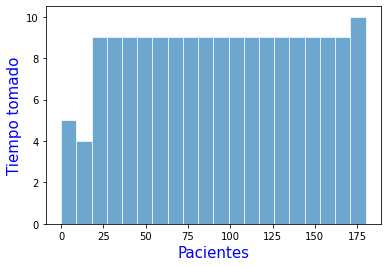

In [83]:
# Generamos la grafica
datos=sorted(tiempo_vacunacion.items())
x, y =zip(*datos)
result = pp.hist(x,bins=20,edgecolor='w',alpha=0.65)
pp.xlabel("Pacientes",fontsize = 15,color = 'b')
pp.ylabel("Tiempo tomado",fontsize = 15,color = 'b')

In [181]:
aux = 0
for val in tuple(tiempo_vacunacion.values()):
    aux = aux+val
print("Tiempo de espera promedio vacunación ",aux/len(tiempo_vacunacion))

Tiempo de espera promedio vacunación  7.511627906976744


In [182]:
tiempo_espera_vacunacion1=[]
for val in tiempo_espera_vacunacion:
    for val1 in tiempo_espera_vacunacion:
        if(val[0] == val1[0] ):
            if(val[1] != val1[1] ):
                if(val[1]<val1[1]):
                    tiempo_espera_vacunacion1.append(val1[1]-val[1])

In [183]:
aux = 0
for val in tiempo_espera_vacunacion1:
    aux = aux+val
print("Tiempo promedio total de vacunación ",suma/len(tiempo_espera_vacunacion1))

Tiempo promedio total de vacunación  12.91812865497076


In [184]:
print("Pacientes atendidos ", len(vacunados))
print("Pacientes no atendidos ", len(no_vacunados))

Pacientes atendidos  172
Pacientes no atendidos  9
